### Name: Rudine Surya Hartanto
### Class: Data Mining
### Regression Lab

### Msc Computing Enterprise Software Systems, Waterford Institute of Technology, Ireland

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import numpy as np;
import pandas as pd;
import seaborn as sb;
import statsmodels.api as sm;
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from statsmodels.stats import diagnostic as diag
import matplotlib.pyplot as plt;
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import zscore
from patsy import dmatrices
from math import exp, expm1
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.compat import lzip

## loading of data and data preparation

In [3]:
baseData = pd.read_csv('./regression_lab.csv')
baseData.rename(columns={'model year':'model_year'}, inplace=True)
baseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
car name        398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


### as we can see, horsepower should be a numerical attribute but listed as object upon exploring the data, we noticed that there are missing values listed as '?' hence we drop rows that contains '?' as values

In [4]:
baseData = baseData.replace('?', np.nan).dropna()
baseData.horsepower = baseData.horsepower.astype('float')
baseData.drop(['car name'], axis=1);

In [5]:
baseData.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


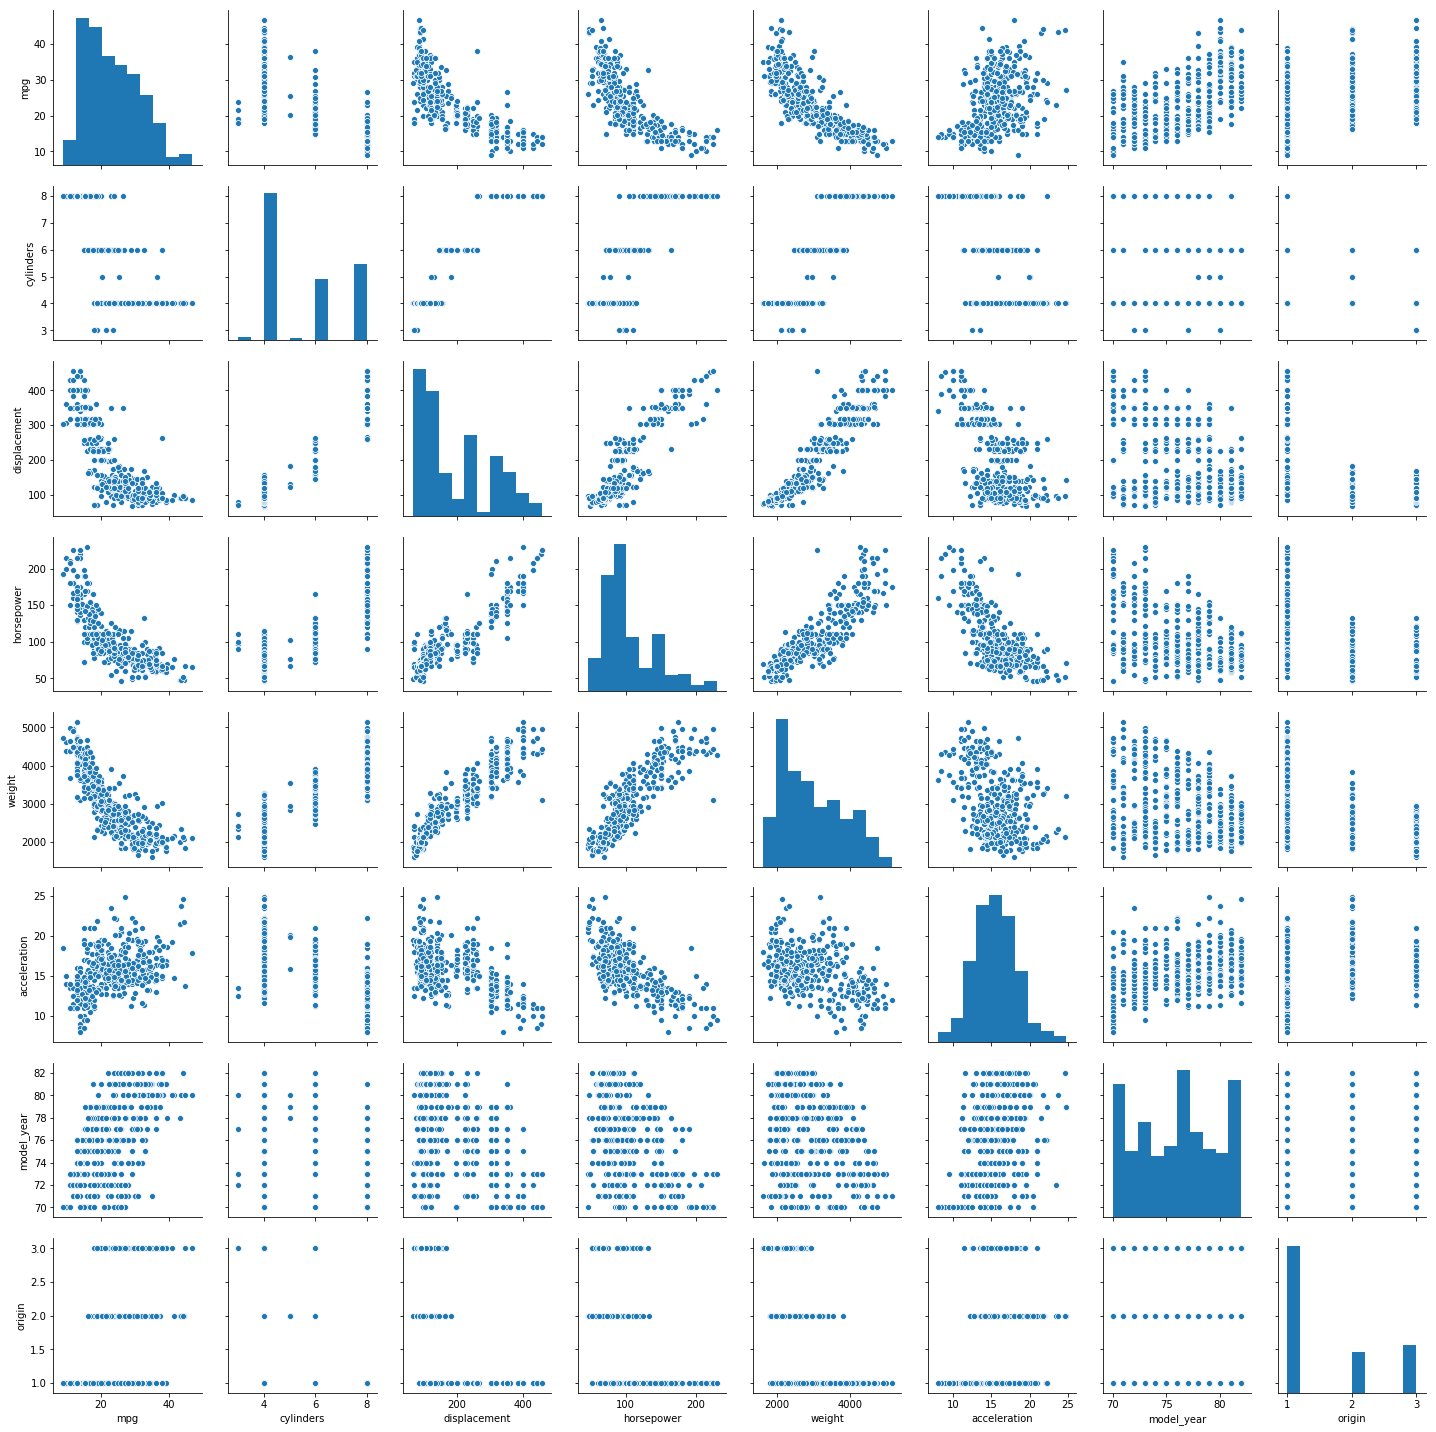

In [6]:
sb.pairplot(baseData)

In [7]:
print("mpg shapiro test: ", stats.shapiro(baseData["mpg"]))
print("displacement shapiro test: ", stats.shapiro(baseData["displacement"]))
print("horsepower shapiro test: ", stats.shapiro(baseData["horsepower"]))
print("weight shapiro test: ", stats.shapiro(baseData["weight"]))
print("acceleration shapiro test: ", stats.shapiro(baseData["acceleration"]))

mpg shapiro test:  (0.9671697616577148, 1.0494927948911936e-07)
displacement shapiro test:  (0.8818366527557373, 8.984704126397468e-17)
horsepower shapiro test:  (0.9040973782539368, 5.021926207130975e-15)
weight shapiro test:  (0.9414661526679993, 2.601725432316293e-11)
acceleration shapiro test:  (0.9918678402900696, 0.03054318018257618)


### as we can see both from the pair plots and the shapiro wilk test results, all of the numeric variables, except for acceleration with p-val of more than 0.05, reject the null hypothesis, which means that they are not normally distributed.

### there also appears to be some outlier present in the data, and for detecting and removal of outlier, a 3 sigma rule is implemented by using the zscore

In [8]:
test = baseData.loc[:, ['mpg', 'horsepower', 'weight', 'acceleration', 'displacement']]

treshold = 3
z = np.abs(zscore(test))
print("outlier detection: ", np.where(z > treshold))

print("count of data before outlier removal: ", baseData.shape[0])
baseData = baseData[(z < treshold).all(axis=1)]
print("count of data after: ", baseData.shape[0])

outlier detection:  (array([  6,   8,  13,  94, 115, 297, 388]), array([1, 1, 1, 1, 1, 3, 3]))
count of data before outlier removal:  392
count of data after:  385


## Correlation between numeric attributes

### Spearman’s Rank correlation coefficient is a technique which can be used to summarise the strength and direction (negative or positive) of a relationship between two variables.

### The technique is mostly used when the variables are not normally distributed or the relationship between the variables is not linear. 

### The result will always be between -1 and 1.

In [9]:
## Check Correlation
corr = baseData[['horsepower', 'weight', 'acceleration', 'displacement']].corr(method="spearman")

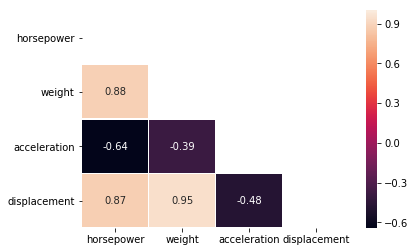

In [10]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr,mask=mask,annot=True,linewidths=.5)

### from the heatmap, it can be established that weight, displacement and horsepower are all strongly correlated everything except acceleration show positive correlation with the other. This is something that have to be put into consideration when modelling the linear regression

/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

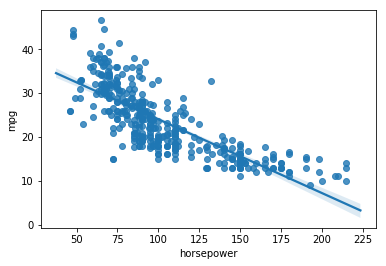

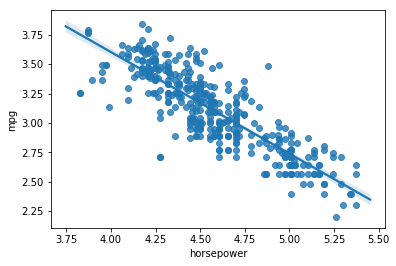

In [11]:
plt.figure()
sb.regplot(baseData["horsepower"], baseData["mpg"])
plt.plot()
plt.figure()
sb.regplot(np.log(baseData["horsepower"]), np.log(baseData["mpg"]))
plt.plot()

### By applying log transform on both predictor and dependent var, it improves the linear dependency. We will be applying this transformation later on in the stepwise regression models.

## Correlation between categorical attributes

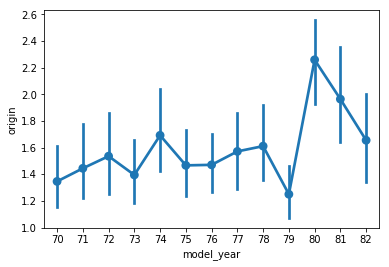

In [12]:
sb.pointplot(baseData["model_year"], baseData["origin"])

### no correlation spotted for model_year and origin

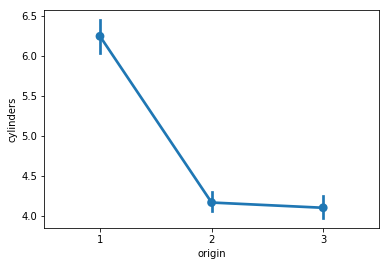

In [13]:
sb.pointplot(baseData["origin"], baseData["cylinders"])

### some form of correlation can be seen here: 
### cars manufactured from origin 1 appears to have bigger cylinders

[]

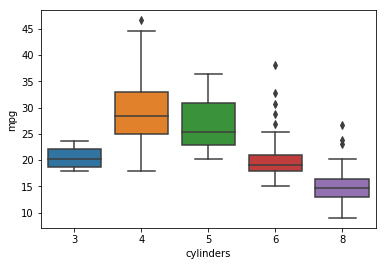

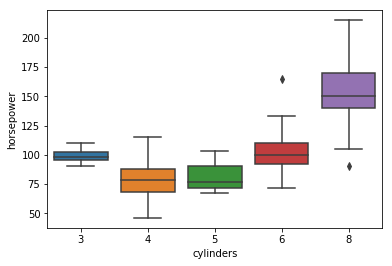

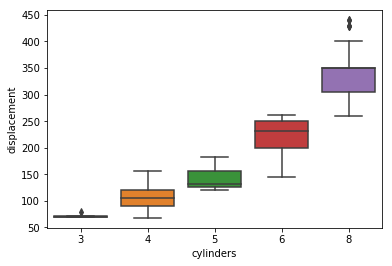

In [14]:
plt.figure()
sb.boxplot(baseData["cylinders"], baseData["mpg"])
plt.plot()
plt.figure()
sb.boxplot(baseData["cylinders"], baseData["horsepower"])
plt.plot()
plt.figure()
sb.boxplot(baseData["cylinders"], baseData["displacement"])
plt.plot()

### we can spot some observations from the graph plot above: 
### as cylinder increases, horsepower increase too.
### as cylinder increases, mpg decreases.
### as cylinder increases, displacement increases
### it makes sense that with higher horsepower, the engine will use up more energy, hence mpg decreases as a result.
### however, there seems to be an obvious outlier or inconsistency in the presented data as cars with cylinders of 3 appear to have the opposite correlation with the others.

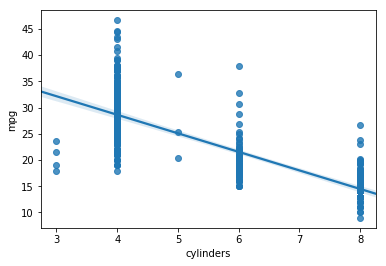

In [15]:
sb.regplot(baseData["cylinders"], baseData["mpg"])

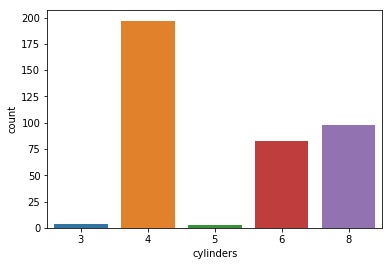

In [16]:
sb.countplot(baseData["cylinders"])

### upon plotting the count of the cylinders, we notice that there are too few data on cars that have 3 and 5 cylinders, and may present a biasness in the correlation. We may choose to remove this data but we will keep it for now.

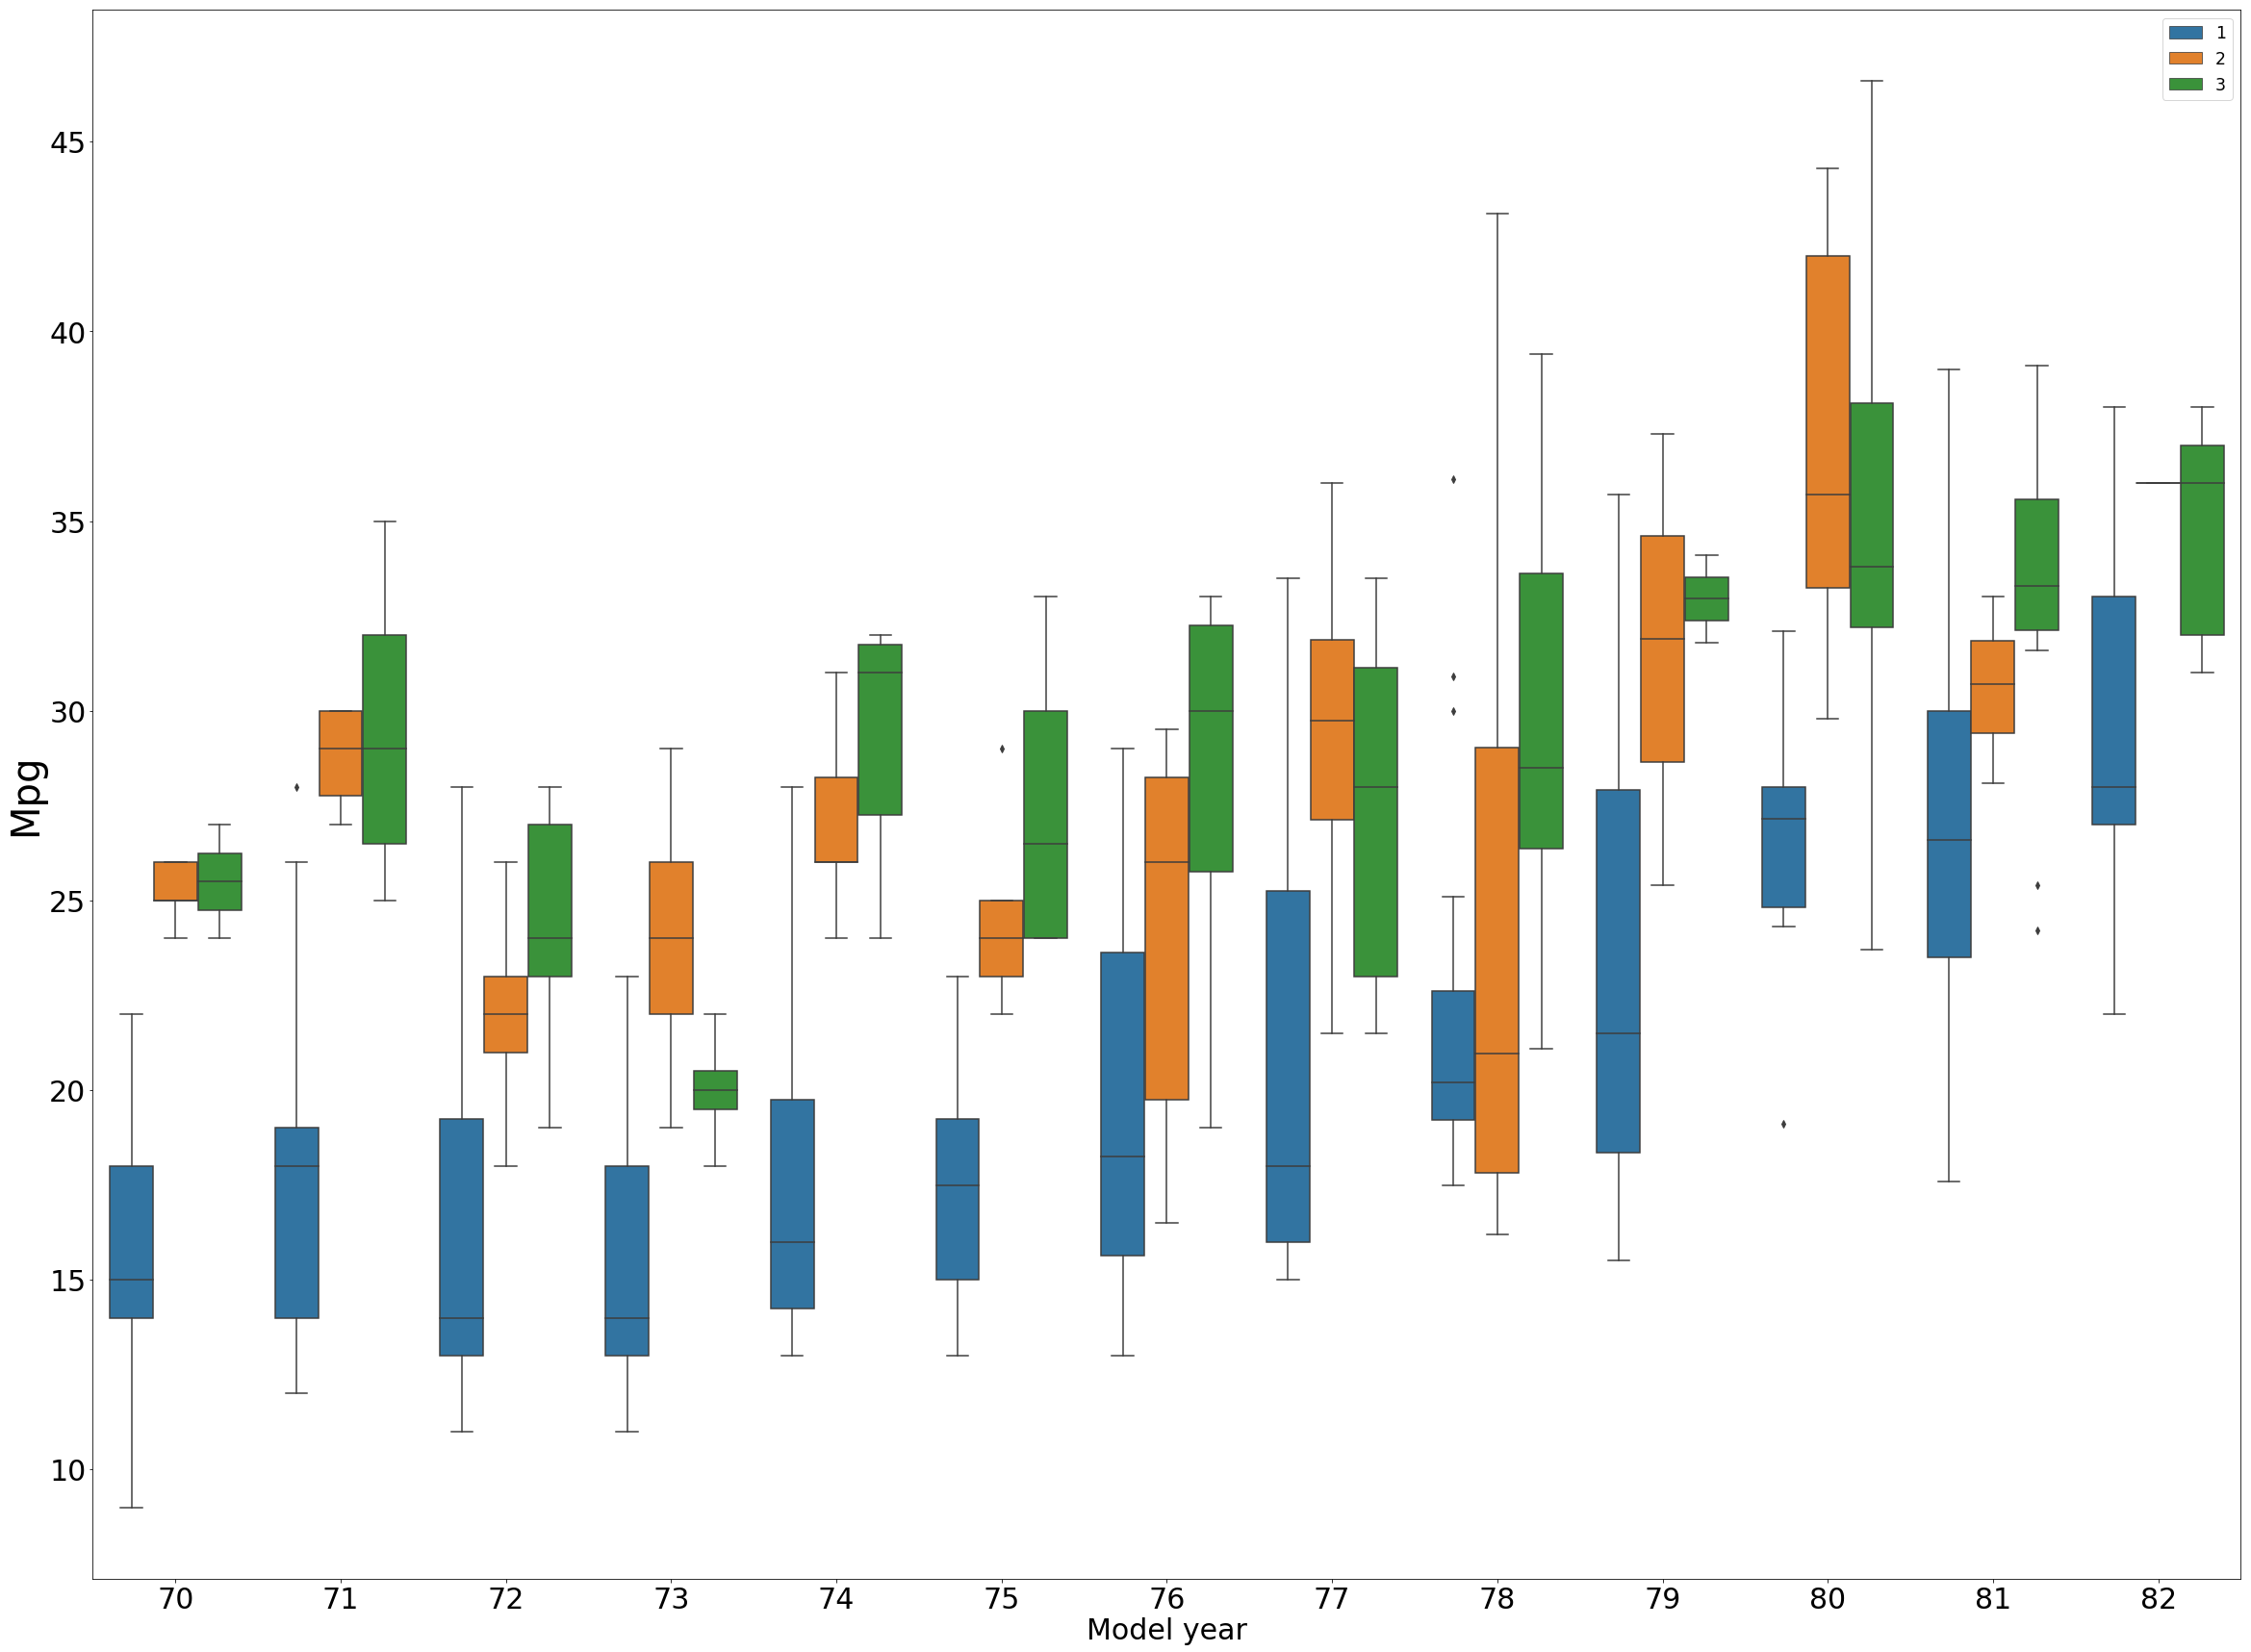

In [17]:
fig = plt.figure(figsize=(40,30))
fontsize2use = 30
plt.xticks(fontsize=fontsize2use) 
plt.yticks(fontsize=fontsize2use)
g = sb.boxplot(baseData["model_year"], baseData["mpg"], baseData["origin"])
g.set_xlabel('Model year',fontsize=30)
g.set_ylabel('Mpg',fontsize=40)
g.legend(fontsize ='xx-large')

### from previous graphs, we have seen that cars manufactured from origin 1 has larger cylinders, which in turn reflect that they will have lower mpg. the last graph above shows the correlation of model_year, origin and mpg as model_year increases, the mpg goes up. this can be due to better technology. and the trend that cars from origin 1 have lower mpg still maintains

## Linear Regression methodology

### In each iteration, the assumptions of linear regression will be satisfied

### Predictor independence
#### refers to when the predictor variables are highly correlated with each other. This is an issue, as the regression model will not be able to accurately associate variance in the outcome variable with the correct predictor variable, leading to muddled results and incorrect inferences.
#### using vif to check for multicollinearity. Values above 10 will be considered as multicollinear and have to be rejected.

### Normality of residuals
#### In order to make valid inferences from the regression, the residuals of the regression should follow a normal distribution. If we examine a normal Predicted Probability (Q-Q) plot, we can determine if the residuals are normally distributed. If they are, they will conform to the diagonal normality line indicated in the plot.

### Homoscedasticity of Residuals
#### refers to whether these residuals are equally distributed. it will appear to be randomly scattered and does not have an obvious pattern.
#### error variance is similar across outcome and around 0

### Linear Dependency between predictors and dependent variable
#### the predictor variables in the regression have a straight-line relationship with the outcome variable.
#### mean error is similar across outcome and around 0

In [18]:
def reg(y, X):
    results = sm.OLS(y, X).fit()
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("rsquared adj: ", results.rsquared_adj)
    print("vif")
    print (pd.Series(vif, index=X.columns))
    print("")
    return results

In [19]:
def displayGraph():
    plt.figure();
    ax = sb.residplot(baseData.mpg,results.resid,lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals');
    plt.show();

    plt.figure();
    plt.hist(results.resid, bins=9);
    plt.show();

    plt.figure();
    stats.probplot(results.resid, dist="norm",plot=plt);
    plt.show();
    
    # Checking normality of residuals
    print(stats.kstest(results.resid, 'norm'))
    print("if above 5% level of significance we can say that the residuals are normally distributed.") 
    
    print("")
    # Checking Homoscedasticity
    name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
    test = sms.het_breuschpagan(results.resid, results.model.exog)
    print(lzip(name, test))
    print("if above 5% level of significance we can say that the residuals have constant variance")
    print("Hence we can say that all the assumptions of our linear regression model are satisfied.")

### Begin with 1 predictor

In [20]:
y, X = dmatrices("mpg ~ weight", data=baseData, return_type="dataframe")
results = reg(y,X)

rsquared adj:  0.6940751012836378
vif
Intercept    13.442751
weight        1.000000
dtype: float64



#### ranked from highest rsquared to lowest
#### weight, displacement, horsepower, cylinders, model_year, acceleration

#### it makes sense that weight is the most responsible for the change in mpg. Heavier cars need bigger engine and more horsepower, which in turn means more fuel to drive.

### Try with 2 predictors

rsquared adj:  0.7068487293959509
vif
Intercept     13.701268
weight         4.380712
horsepower     4.380712
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     464.0
Date:                Sun, 24 Feb 2019   Prob (F-statistic):          6.04e-103
Time:                        23:54:03   Log-Likelihood:                -1095.8
No. Observations:                 385   AIC:                             2198.
Df Residuals:                     382   BIC:                             2209.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

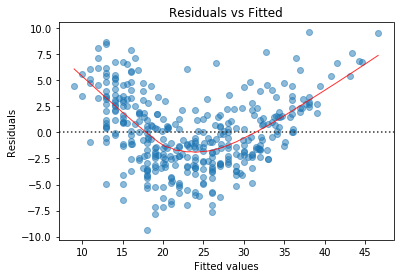

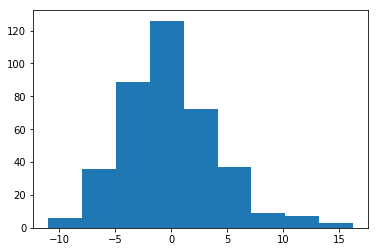

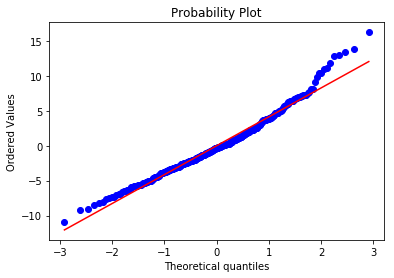

KstestResult(statistic=0.3192987420403526, pvalue=0.0)
if above 5% level of significance we can say that the residuals are normally distributed.

[('Lagrange multiplier statistic', 26.1172436413537), ('p-value', 2.1316338199076157e-06), ('f-value', 13.899786064152511), ('f p-value', 1.4891748670805036e-06)]
if above 5% level of significance we can say that the residuals have constant variance
Hence we can say that all the assumptions of our linear regression model are satisfied.


In [21]:
y, X = dmatrices("mpg ~ weight + horsepower", data=baseData, return_type="dataframe")
results = reg(y,X)
print(results.summary())
displayGraph()

#### vif values are below treshold, which means no multicollinearity
#### choosing horsepower as 2nd predictor leads to the best adjusted r-squared value
#### as we can see from the coeff values, horsepower is the most significant predictor

### Try with 3 predictors

rsquared adj:  0.7183483990404127
vif
Intercept               377.335872
weight                   10.248622
horsepower                4.530035
np.log(displacement)      8.661859
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 24 Feb 2019   Prob (F-statistic):          4.40e-105
Time:                        23:54:04   Log-Likelihood:                -1087.6
No. Observations:                 385   AIC:                             2183.
Df Residuals:                     381   BIC:                             2199.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                

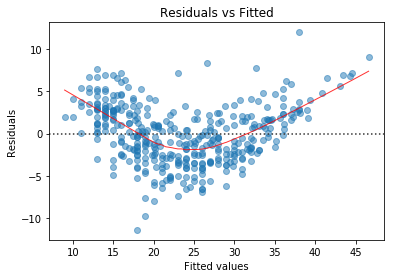

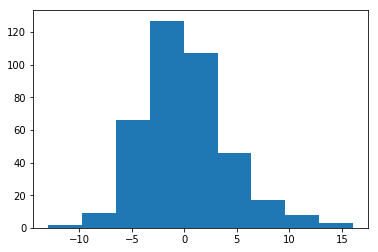

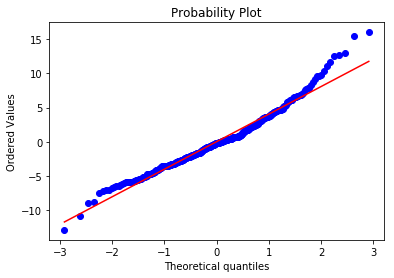

KstestResult(statistic=0.31977151945861176, pvalue=0.0)
if above 5% level of significance we can say that the residuals are normally distributed.

[('Lagrange multiplier statistic', 28.52489116910229), ('p-value', 2.818029604377117e-06), ('f-value', 10.162451988182116), ('f p-value', 1.8748623747249005e-06)]
if above 5% level of significance we can say that the residuals have constant variance
Hence we can say that all the assumptions of our linear regression model are satisfied.


In [22]:
y, X = dmatrices("mpg ~ weight + horsepower + np.log(displacement)", data=baseData, return_type="dataframe")
results = reg(y,X)
print(results.summary())
displayGraph()

#### vif values show that there exist multicollinearity due to weight
#### although this model has a really good adj r-squared value, and good p-vals on the coefficient
#### we will now explore ways to reduce this multicollinearity

rsquared adj:  0.7267364543513581
vif
Intercept               260.152466
m                         1.979965
horsepower                4.097653
np.log(displacement)      5.867909
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     341.4
Date:                Sun, 24 Feb 2019   Prob (F-statistic):          1.40e-107
Time:                        23:54:04   Log-Likelihood:                -1081.8
No. Observations:                 385   AIC:                             2172.
Df Residuals:                     381   BIC:                             2187.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                

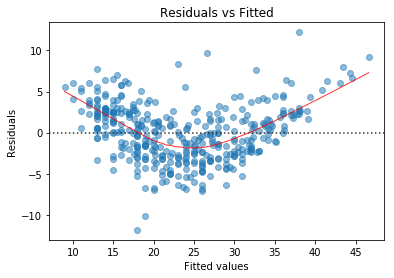

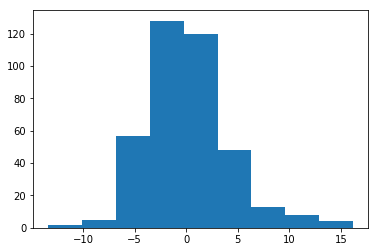

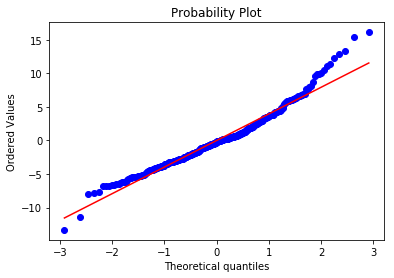

KstestResult(statistic=0.3132892502647383, pvalue=0.0)
if above 5% level of significance we can say that the residuals are normally distributed.

[('Lagrange multiplier statistic', 27.087137932252702), ('p-value', 5.644837183563467e-06), ('f-value', 9.611463800216665), ('f p-value', 3.939960105087926e-06)]
if above 5% level of significance we can say that the residuals have constant variance
Hence we can say that all the assumptions of our linear regression model are satisfied.


In [23]:
m = baseData["weight"]*baseData["acceleration"]
y, X = dmatrices("mpg ~ m + horsepower + np.log(displacement)", data=baseData, return_type="dataframe")
results = reg(y,X)
print(results.summary())
displayGraph()

#### the multicollinearity is fixed as shown by the low vif values.
#### acceleration does not posses a strong correlation with mpg, hence we try to use moderation (acceleration*weight)

### Try with 4 predictors

rsquared adj:  0.8778602826237806
vif
Intercept             2327.868663
np.log(horsepower)       1.508805
np.log(m)                1.318644
model_year               1.166696
dtype: float64

                            OLS Regression Results                            
Dep. Variable:            np.log(mpg)   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     921.0
Date:                Sun, 24 Feb 2019   Prob (F-statistic):          3.65e-174
Time:                        23:54:05   Log-Likelihood:                 279.37
No. Observations:                 385   AIC:                            -550.7
Df Residuals:                     381   BIC:                            -534.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    

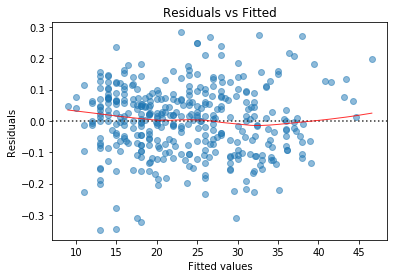

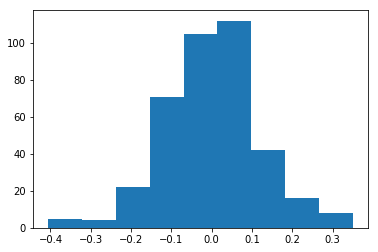

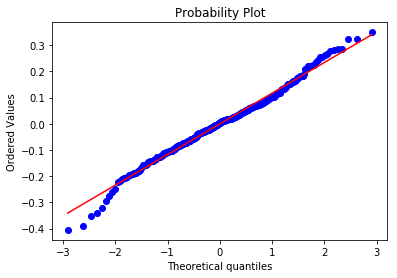

KstestResult(statistic=0.38809388401708583, pvalue=0.0)
if above 5% level of significance we can say that the residuals are normally distributed.

[('Lagrange multiplier statistic', 4.14022396542502), ('p-value', 0.24671515731733343), ('f-value', 1.3805827674520443), ('f p-value', 0.2483001756760062)]
if above 5% level of significance we can say that the residuals have constant variance
Hence we can say that all the assumptions of our linear regression model are satisfied.


In [24]:
m = baseData["weight"]*baseData["acceleration"]
y, X = dmatrices("np.log(mpg) ~ np.log(horsepower) + np.log(m) + model_year", data=baseData, return_type="dataframe")
results = reg(y,X)
print(results.summary())
displayGraph()

#### Tried using displacement, origin, cylinders as the 4th predictor
#### displacement is highly correlated with weight and horsepower, so introducing it into the formula will cause multicollinearity
#### categorical var origin and cylinders are linearly correlated with mpg, hence they wont be significant in the formula.
#### the best outcome results from adding model_year as there exists some form of linear dependency between it and mpg.
#### also apply log transform on mpg and some other predictor to gain better residual

rsquared adj:  0.8830439384162798
vif
Intercept             2985.032779
C(origin)[T.2]           1.357677
C(origin)[T.3]           1.506770
np.log(horsepower)       1.743950
np.log(m)                1.517786
model_year               1.210526
dtype: float64

                            OLS Regression Results                            
Dep. Variable:            np.log(mpg)   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     580.9
Date:                Sun, 24 Feb 2019   Prob (F-statistic):          3.38e-175
Time:                        23:54:05   Log-Likelihood:                 288.73
No. Observations:                 385   AIC:                            -565.5
Df Residuals:                     379   BIC:                            -541.7
Df Model:                           5                                         
Covariance Type:            non

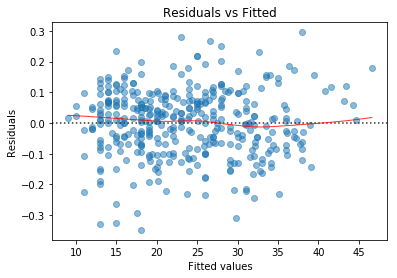

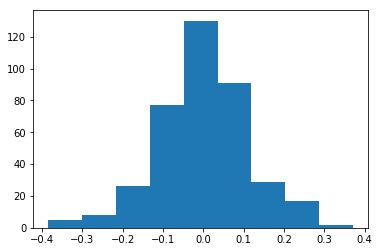

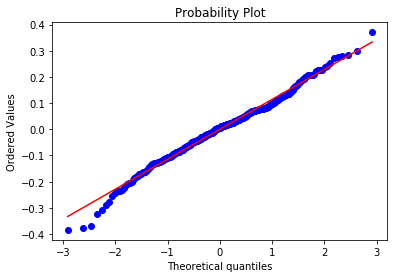

KstestResult(statistic=0.38673344986104297, pvalue=0.0)
if above 5% level of significance we can say that the residuals are normally distributed.

[('Lagrange multiplier statistic', 6.376339511782109), ('p-value', 0.2713018700608636), ('f-value', 1.2765354768633757), ('f p-value', 0.2732356978889894)]
if above 5% level of significance we can say that the residuals have constant variance
Hence we can say that all the assumptions of our linear regression model are satisfied.


In [25]:
m = baseData["weight"]*baseData["acceleration"]
y, X = dmatrices("np.log(mpg) ~ np.log(horsepower) + np.log(m) + model_year + C(origin)", data=baseData, return_type="dataframe")
results = reg(y,X)
print(results.summary())
displayGraph()

#### similar with previous model, but higher adj r-squared
#### all the assumptions of linear regression have been satisfied.

#### Predictor independence
##### Shown by vif values below the threshold (10) 

#### Normality of residuals
##### Q-Q Plot conform to the diagonal normality line
##### distribution plot show symmetric bellcurve with the mean right at the center (0)
##### Kolmogorov-Smirnov p-val > 5% [not 100% working for me]

#### Homoscedasticity of Residuals
##### Shown by the residual plot, points have no obvious pattern and distributed equally.

#### Linear Dependency between predictors and dependent variable
##### all predictors used in each models have good linear dependency with the dependent variable.
##### this is shown by their strong coefficients in the model.


### this is the best model so far, and we will stop here.

#### References: 

#### https://www.statisticssolutions.com/testing-assumptions-of-linear-regression-in-spss/
#### https://pythonfordatascience.org/linear-regression-python/